### 数据集
约5000部较受欢迎的英文电影的基本信息，包含的属性有：
* 文字描述：
title, cast, crew, genres, keywords, original_language, original_title, overview, production_companies, tagline,production_countries,spoken_languages
* 数值参数:
popularity, release_date, revenue, runtime, vote_average, vote_count, budget

### 目标
**content-based filtering**
<br>根据数据集提供的电影信息，主要是文字描述信息，找到相似电影。这里主要是做一个基于内容的相似匹配，暂不考虑用户的喜好品味评分等信息。
<br>基于用户的相关推荐方法请查看：

### 输入-词向量
* 一种方案是用电影的剧情概述来定义电影：输入电影的overview信息，分词统计词频，定义词向量
* 一种方案是用电影的关键词、类型、导演、演员等这些人们预先概括出的文字标签或者说是元信息来定义电影
#### TF-IDF 词频
<br>TF: term instances/total instances 输入文本中当前词的个数/输入文本所有词的个数
<br>IDF: log(number of documents/documents with term) log(输入文本数/包含当前词的文本数)
<br>TF*IDF 这种统计词频的方法可以突出输入文本中独特的高频词，一些所有文本中都经常用到的词的权重被削弱了

### 关键指标-相似度
<br>通过把文本转换成词向量，构建了一个欧式空间，比较电影之间的相似度就转换成了度量词向量之间的距离，有很多种指标可以选，如euclidean，Pearson还有cosine，这里选用余弦来度量词向量之间夹角的大小：
<br>**$similarity = cos(\theta)=\frac{A·B}{||A||·||B||}=\frac{\sum_{i=1}^n A_i·B_i}{\sqrt{\sum_{i=1}^n A_i^2}\sqrt{\sum_{i=1}^n B_i^2}}$**
<br>用sklearn里的linear_kernel()方法求TF·IDF矩阵和自己的转置矩阵的点积，所得到的结果就是cosine值。标签信息计算相似度时不需要用到TF-IDF对常用词过滤，直接用sklearn里的CountVectorizer()统计词频即刻，对应的相似度计算也用sklearn库里的cosine_similarity即可

### 数据载入和清洗

In [1]:
import pandas as pd
import numpy as np
df_credits = pd.read_csv('../movie_filter/input/tmdb_5000_credits.csv')
df_credits.columns = ['id','title','cast','crew']
df_movies = pd.read_csv('../movie_filter/input/tmdb_5000_movies.csv')
df_movies = df_movies.merge(df_credits[['id','cast','crew']], on='id',how='outer')
df_movies.drop(columns=['budget','homepage','popularity', 'release_date', 'revenue', 'runtime', 'vote_average', 'vote_count'], inplace=True)
print('Dataset Shape: ',df_movies.shape)
df_movies.head(3)

Dataset Shape:  (4803, 14)


,genres,id,keywords,original_language,original_title,overview,production_companies,production_countries,spoken_languages,status,tagline,title,cast,crew
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [17]:
df_movies[['cast','crew','keywords','genres']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 4 columns):
cast        4803 non-null object
crew        4803 non-null object
keywords    4803 non-null object
genres      4803 non-null object
dtypes: object(4)
memory usage: 187.6+ KB


### 电影描述文本-->词向量
根据两种定义电影的方式，准备两套数据：
* overview 剧情概括
* metadata 电影标签
<br>这里选取电影的类型标签，剧情关键词，导演，制片，编剧和前三位主演作为元信息，合并成一个长文本统计词频组成词向量，注意清理数据时要把关键词，人员姓名里的空格去掉

#### 剧情概括词向量：

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
overview = df_movies['overview'].fillna('')
overview_tfidf = TfidfVectorizer(stop_words='english')
overview_tfidf_matrix = overview_tfidf.fit_transform(overview)
overview_tfidf_matrix.shape

(4803, 20978)

#### 电影标签词向量：
先把所有需要的属性column提取出来，把他们由dataframe object转换成对应的python object

In [4]:
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
features = ['cast','crew','keywords','genres']
for feature in features:
    df_movies[feature] = df_movies[feature].apply(literal_eval)
df_meta = df_movies[features].copy()

获取导演、制片、编剧、主演的方法：

In [5]:
def get_crew(crews,job='Director'):
    names = []
    for i in crews:
        if i['job'] == job:
            names.append(i['name'])
    return names

def get_list(casts,limit=3):
    if isinstance(casts,list):
        names = [i['name'] for i in casts]
        if len(names)>limit:
            names = names[:limit]
        return names

In [6]:
df_meta['director'] = df_meta['crew'].apply(get_crew)
df_meta['writers'] = df_meta['crew'].apply(get_crew,job='Screenplay')
for feature in  ['keywords','genres']:
    df_meta[feature] = df_meta[feature].apply(get_list, limit=4)
df_meta['cast'] = df_meta['cast'].apply(get_list)
df_meta.head()

,cast,crew,keywords,genres,director,writers
0,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...","[culture clash, future, space war, space colony]","[Action, Adventure, Fantasy, Science Fiction]",[James Cameron],[James Cameron]
1,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]",[Gore Verbinski],"[Ted Elliott, Terry Rossio]"
2,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...","[spy, based on novel, secret agent, sequel]","[Action, Adventure, Crime]",[Sam Mendes],"[John Logan, Robert Wade, Neal Purvis, Jez But..."
3,"[Christian Bale, Michael Caine, Gary Oldman]","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...","[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]",[Christopher Nolan],"[Christopher Nolan, Jonathan Nolan]"
4,"[Taylor Kitsch, Lynn Collins, Samantha Morton]","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...","[based on novel, mars, medallion, space travel]","[Action, Adventure, Science Fiction]",[Andrew Stanton],"[Andrew Stanton, Michael Chabon, Mark Andrews]"


In [7]:
def clean_data(x):
    if isinstance(x,list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x,str):
        return str.lower(x.replace(" ", ""))
    return ''

In [8]:
for feature in ['cast','keywords','director','writers','genres']:
    df_meta[feature] = df_meta[feature].apply(clean_data)

In [9]:
def create_soup(x):
    return ' '.join(x['keywords'])+' '+' '.join(x['cast'])+' '+' '.join(x['writers'])+' '+' '.join(x['director'])+' '+' '.join(x['genres'])
df_meta['soup'] = df_meta.apply(create_soup,axis=1)
df_meta['soup'][:5]

0    cultureclash future spacewar spacecolony samwo...
1    ocean drugabuse exoticisland eastindiatradingc...
2    spy basedonnovel secretagent sequel danielcrai...
3    dccomics crimefighter terrorist secretidentity...
4    basedonnovel mars medallion spacetravel taylor...
Name: soup, dtype: object

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
meta = df_meta['soup']
meta_matrix = count.fit_transform(meta)
print(meta_matrix.shape)

(4803, 14767)


#### 以词云的形式预览下整理好的标签

In [11]:
doc_list = list(df_meta['soup'])
words = []
for doc in doc_list:
    words+=doc.strip().split(' ')
words_dict = pd.Series([word for word in words if word!='']).value_counts()

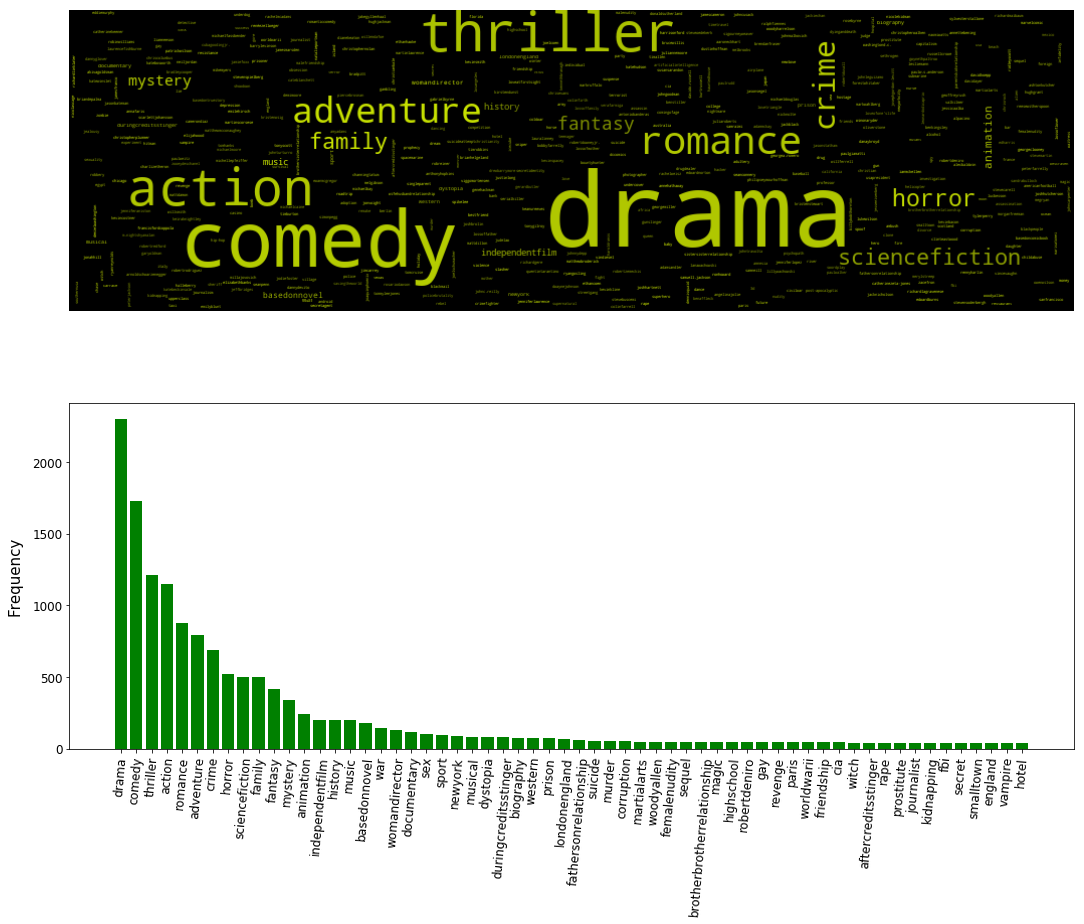

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
tone = 48.0

wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=500,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words_dict.to_dict())

fig = plt.figure(1, figsize=(18,14))
ax1 = fig.add_subplot(2,1,1) 
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')

ax2 = fig.add_subplot(2,1,2)
top_words =  words_dict[:60].to_dict()
y_axis = [i for i in words_dict[:60]]
x_axis = [i for i in words_dict[:60].index]
plt.xticks(rotation=85, fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel("Frequency", fontsize = 15, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
plt.show()

电影类型的权重高，影响大，思考是否应该采取些办法削弱其影响
### 定义获取相似电影的方法
* 输入电影名称，获取ID号
* 从相似度矩阵中提取该电影对应列，排序
* 获取相似度最高的前十部电影，注意第一部一定是自己，要去掉
* 返回十部相似电影的名称

In [24]:
indices = pd.Series(df_movies.index,index=df_movies['title'])

from sklearn.metrics.pairwise import cosine_similarity
overview_cosine = linear_kernel(overview_tfidf_matrix, overview_tfidf_matrix)
meta_cosine = cosine_similarity(meta_matrix,meta_matrix)

def get_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x:x[1],reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    df_recommended = df_movies[['title']].iloc[movie_indices]
    df_recommended.index = range(1,11)
    df_recommended.rename(columns={'title':'相似电影','vote_average':'评分'}, inplace=True)
    return df_recommended

#### 按剧情概括查找：

In [25]:
get_recommendations("Avatar",overview_cosine)

,相似电影
1,Apollo 18
2,The American
3,The Matrix
4,The Inhabited Island
5,Tears of the Sun
6,Hanna
7,The Adventures of Pluto Nash
8,Semi-Pro
9,Supernova
10,Blood and Chocolate


#### 按标签信息查找：

In [26]:
get_recommendations("Avatar",meta_cosine)

,相似电影
1,The Abyss
2,Aliens
3,True Lies
4,The Time Machine
5,The Terminator
6,Teenage Mutant Ninja Turtles
7,Terminator 2: Judgment Day
8,The Helix... Loaded
9,X-Men: Days of Future Past
10,Jupiter Ascending


个人感觉还是按关键词电影类型这些信息查找到的比较准确